# Google Drive Setup

In [1]:
#import to reach my google drive holding data
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pwd

'/content'

In [3]:
#get to the directory with the data
os.chdir('./drive/My Drive/Flatiron/Final Project/dataset')

In [ ]:
#unzip file for the first time
# !unzip -qq data.zip

In [4]:
pwd #be in final project dir

'/content/drive/My Drive/Flatiron/Final Project/dataset'

In [5]:
ls

backup_images/  classified.png  miru/  misclassified.png  test/  train/  val/


# Packages and Functions

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import numpy as np
import itertools

import keras
from keras import models
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
random_seed = 123

Using TensorFlow backend.


In [8]:
def check_data(images,labels):  
    '''
    Checking number of total images and labels to make sure they are the same
    Print the number of class images for jindo and shiba (class imbalance)
    Print the plots of 9 images
    '''
    #find all indexes with a value of 0 and use the first value of the returned tuple
    #taking the length gives the number of indexes with value 0
    num_jindo = len(np.where(labels == 0)[0]) 
    num_shiba = len(np.where(labels == 1)[0])
    
    diff = abs(num_jindo-num_shiba)
    
    print('Number of images: {} and labels: {}'.format(len(images), len(labels)))
    print('Number of Jindo images: {}, Number of Shiba images: {}'.format(num_jindo,num_shiba))
    if num_jindo != num_shiba:
        print('Class is imbalanced by: {}'.format(diff))
    
    #plot with matplotlib    
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow((images[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
    plt.show()

In [10]:
def pickle_save(model,name):
    '''
    saving models with pickle
    '''
    full_name = name + '.pickle'
    with open(full_name, 'wb') as f:
        pickle.dump(model, f)

In [ ]:
def plot_predictions(misclassified,name): 
  '''
  Given a tuple of image array data, true, and pred labels return the plot of the first 9 images with their respective labels
  '''

  save_name = '{}.png'.format(name
                              )
  for i in range(9):
        plt.figure(1 , figsize = (8,8))
        plt.subplots_adjust(hspace = 0.5, wspace = 0.01)
        try:
          img_array = misclassified[i][0]
          true_label = 'Shiba' if misclassified[i][1] == 1 else 'Jindo'
          pred_label = 'Shiba' if float(misclassified[i][2]) == 1 else 'Jindo'
        except IndexError:
          continue

        plt.subplot(330 + 1 + i)
        plt.imshow((img_array*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.title(' True labels: {} \n Pred Label: {}'.format(true_label, pred_label))
        plt.axis('off') #Turn axes on or off

        plt.savefig(save_name, transparent = True, bbox_inches='tight')

  plt.show()

In [ ]:
## Trusty ol' resuable matrix graph code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation = 45)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Loading data and EDA

In [9]:
#Train data
train_data = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './train', 
        target_size=(224, 224), 
        batch_size = 1817,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
         seed = random_seed
) 

X_train, y_train = next(train_data)

Found 1817 images belonging to 2 classes.


In [11]:
#Test Data
train_data = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './test', 
        target_size=(224, 224), 
        batch_size = 30,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
         seed = random_seed
) 

X_test, y_test = next(train_data)

Found 30 images belonging to 2 classes.


In [12]:
#Val Data
train_data = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './val', 
        target_size=(224, 224), 
        batch_size = 30,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
         seed = random_seed
) 

X_val, y_val = next(train_data)

Found 30 images belonging to 2 classes.


Number of images: 30 and labels: 30
Number of Jindo images: 15, Number of Shiba images: 15


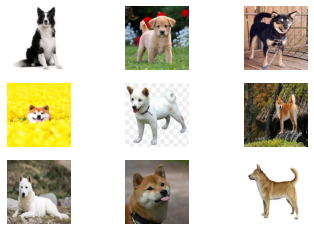

In [13]:
plt.axis('off')
check_data(X_val,y_val)


# Modeling

In [ ]:
cnn_withdrop = models.Sequential()

#feature learning
cnn_withdrop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn_withdrop.add(layers.MaxPooling2D((2, 2)))
cnn_withdrop.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_withdrop.add(layers.MaxPooling2D((2, 2)))

cnn_withdrop.add(Dropout(0.3, input_shape=(224,224,3)))

# cnn_withdrop.add(BatchNormalization())

#classification
cnn_withdrop.add(layers.Flatten())
cnn_withdrop.add(layers.Dense(32, activation='relu'))

cnn_withdrop.add(Dropout(0.3, input_shape=(224,224,3)))

cnn_withdrop.add(layers.Dense(1, activation='sigmoid'))

cnn_withdrop.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
cnn_dropout = cnn_withdrop.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=260,
                    validation_data=(X_val, y_val))

Train on 1817 samples, validate on 30 samples
Epoch 1/5
1817/1817 [==============================] - 16s 9ms/step - loss: 1.1584 - acc: 0.5289 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 2/5
1817/1817 [==============================] - 3s 2ms/step - loss: 0.6912 - acc: 0.5118 - val_loss: 0.6918 - val_acc: 0.4667
Epoch 3/5
1817/1817 [==============================] - 3s 2ms/step - loss: 0.6876 - acc: 0.5867 - val_loss: 0.6718 - val_acc: 0.6000
Epoch 4/5
1817/1817 [==============================] - 3s 2ms/step - loss: 0.6667 - acc: 0.6142 - val_loss: 0.6643 - val_acc: 0.7000
Epoch 5/5
1817/1817 [==============================] - 3s 2ms/step - loss: 0.6380 - acc: 0.6362 - val_loss: 0.6765 - val_acc: 0.6333


In [ ]:
results_train_dropout = cnn_withdrop.evaluate(X_train, y_train)
results_test_dropout = cnn_withdrop.evaluate(X_test, y_test)
print('Train: ',results_train_dropout[1], ' Test: ',results_test_dropout[1])

predictions_dropout = cnn_withdrop.predict(X_test)
predictions_dropout = np.around(predictions_dropout)

print('F1: ',f1_score(y_test,predictions_dropout))
confusion_matrix(y_test, predictions_dropout)

30/30 [==============================] - 0s 906us/step
Train:  0.7193175554275513  Test:  0.6000000238418579
F1:  0.6470588235294117


array([[ 7,  8],
       [ 4, 11]])

In [ ]:
def make_alex():
  '''
  Make a model with the same structure as an AlexNet. The structural alexnet code is from https://engmrk.com/alexnet-implementation-using-keras/, and
  changes of dropout regularization perecent and learning rate have been adjusted for my model
  '''
  #clear an existing models
  keras.backend.clear_session()

  #Instantiate an empty model
  model = Sequential()

  # 1st Convolutional Layer
  model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
  model.add(Activation('relu'))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))

  # 4th Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))

  # 5th Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # Passing it to a Fully Connected layer
  model.add(Flatten())
  # 1st Fully Connected Layer
  model.add(Dense(4096, input_shape=(224*224*3,)))
  model.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  model.add(Dropout(0.1))

  # 2nd Fully Connected Layer
  model.add(Dense(4096))
  model.add(Activation('relu'))
  # Add Dropout
  model.add(Dropout(0.1))

  # 3rd Fully Connected Layer
  model.add(Dense(1000))
  model.add(Activation('relu'))
  # Add Dropout
  model.add(Dropout(0.1))

  # Output Layer
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  # model.summary() #Print the summary if needed

  #Step own optimizer's learning rate
  optimizer = keras.optimizers.Adam(lr=0.0001)

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"]) 
  
  return model

In [ ]:
model_test = make_alex()

In [ ]:
 cnn = model_test.fit(X_train,
                    y_train,
                    epochs=15,
                    batch_size=300,
                    shuffle = False,
                    validation_data=(X_val, y_val))

Train on 1817 samples, validate on 30 samples
Epoch 1/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5184 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6938 - accuracy: 0.5014 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 3/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6877 - accuracy: 0.5014 - val_loss: 0.6756 - val_accuracy: 0.5000
Epoch 4/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6851 - accuracy: 0.5366 - val_loss: 0.6894 - val_accuracy: 0.6000
Epoch 5/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6773 - accuracy: 0.5724 - val_loss: 0.6715 - val_accuracy: 0.5333
Epoch 6/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6693 - accuracy: 0.5988 - val_loss: 0.6526 - val_accuracy: 0.6667
Epoch 7/15
1817/1817 [==============================] - 2s 1ms/step - loss: 0.6528 - accur

In [ ]:
results_train = model_test.evaluate(X_train, y_train)
results_test = model_test.evaluate(X_test, y_test)
print('Train: ',results_train[1], ' Test: ',results_test[1])

predictions = model_test.predict(X_test)
predictions = np.around(predictions)

print('F1: ',f1_score(y_test,predictions))
confusion_matrix(y_test, predictions)

30/30 [==============================] - 0s 598us/step
Train:  0.7930654883384705  Test:  0.6666666865348816
F1:  0.6666666666666666


array([[10,  5],
       [ 5, 10]])

##Visualizing wrong labels for intial model

In [ ]:
#check how many classified and misclassified for this model
classified = []
misclassified = []

for x,y,z in zip(X_test, y_test, predictions_dropout):
  if y != z:
    misclassified.append((x,y,z))
  else:
    classified.append((x,y,z))

len(classified),len(misclassified)

(18, 12)

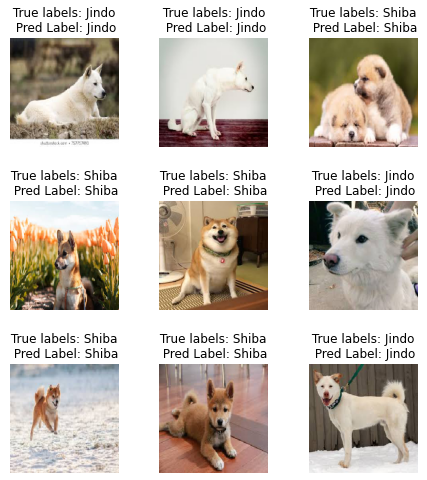

In [ ]:
plot_predictions(classified,'classified')

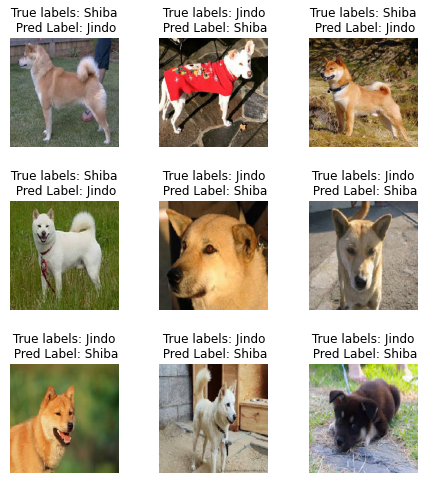

In [ ]:
plot_predictions(misclassified, 'misclassified')

# Transfer Learning

In [14]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,GlobalAveragePooling2D

In [15]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# mark loaded layers as not trainable
for layer in model.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [18]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
def make_model():

  keras.backend.clear_session()
  
  new_model = models.Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())
  new_model.add(Dense(1000,activation='relu'))
  new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation
  return new_model

In [20]:
transfer_model = make_model()

In [21]:
optimizer = keras.optimizers.Adam(lr=0.0001)

transfer_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"]) 

In [22]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              513000    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 15,228,689
Trainable params: 514,001
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
cnn = transfer_model.fit(X_train,
                    y_train,
                    epochs=15,
                    batch_size = 50,
                    # shuffle = False,
                    validation_data=(X_val, y_val))

Train on 1817 samples, validate on 30 samples
Epoch 1/15
1817/1817 [==============================] - 24s 13ms/step - loss: 0.6671 - accuracy: 0.6153 - val_loss: 0.6455 - val_accuracy: 0.6000
Epoch 2/15
1817/1817 [==============================] - 9s 5ms/step - loss: 0.6150 - accuracy: 0.7039 - val_loss: 0.5977 - val_accuracy: 0.6333
Epoch 3/15
1817/1817 [==============================] - 9s 5ms/step - loss: 0.5825 - accuracy: 0.7210 - val_loss: 0.5687 - val_accuracy: 0.6667
Epoch 4/15
1817/1817 [==============================] - 9s 5ms/step - loss: 0.5634 - accuracy: 0.7309 - val_loss: 0.5560 - val_accuracy: 0.6667
Epoch 5/15
1817/1817 [==============================] - 9s 5ms/step - loss: 0.5387 - accuracy: 0.7556 - val_loss: 0.5287 - val_accuracy: 0.7333
Epoch 6/15
1817/1817 [==============================] - 10s 5ms/step - loss: 0.5266 - accuracy: 0.7529 - val_loss: 0.5167 - val_accuracy: 0.7000
Epoch 7/15
1817/1817 [==============================] - 10s 5ms/step - loss: 0.5096 - a

In [24]:
results_train = transfer_model.evaluate(X_train, y_train)
results_test = transfer_model.evaluate(X_test, y_test)
print('Train: ',results_train[1], ' Test: ',results_test[1])

predictions = transfer_model.predict(X_test)
predictions = np.around(predictions)

print('F1: ',f1_score(y_test,predictions))
confusion_matrix(y_test, predictions)

30/30 [==============================] - 0s 5ms/step
Train:  0.8161805272102356  Test:  0.8333333134651184
F1:  0.8148148148148148


array([[14,  1],
       [ 4, 11]])

[[14  1]
 [ 4 11]]


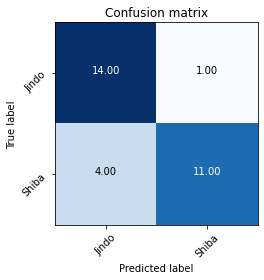

In [30]:
plot_confusion_matrix(confusion_matrix(y_test,predictions), ['Jindo','Shiba'], normalize = False)
# plt.savefig('confusion_matrix.png', transparent = True)        

In [ ]:
pickle_save(new_model2, 'transfer_model1')

In [25]:
#check how many images are classified and misclassified
classified = []
misclassified = []

for x,y,z in zip(X_test, y_test, predictions):
  if y != z:
    misclassified.append((x,y,z))
  else:
    classified.append((x,y,z))

len(classified),len(misclassified)

(25, 5)

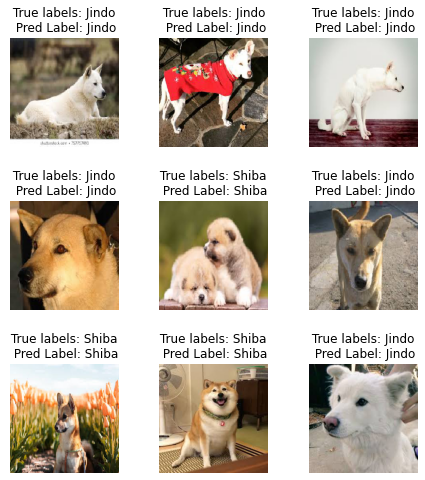

In [28]:
plot_predictions(classified,'classified')
# plt.savefig('classified.png', transparent = True)        

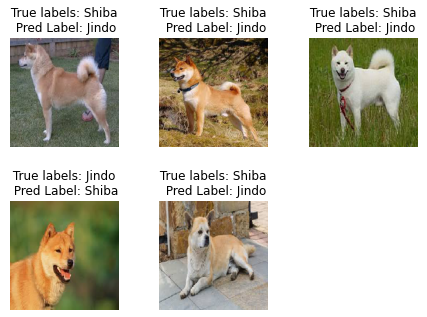

In [29]:
plot_predictions(misclassified, 'misclassified')
# plt.savefig('confusion_matrix.png', transparent = True)        